In [193]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Exploratory Data Analysis for the `Sekundärregelleistungsmarkt`: marginal price

In this notebook, we analyze the marginal price of `Sekundärregelleistungsmarkt` in Germany and Austria.
In a simplied version of explaining, the regelleistungsmarkt is aimed for stabilizing the electricity frequency control by requesting electricity in a very short period of time.  

Data for this analysis are taken from [regelleistung.net](https://www.regelleistung.net/ext/) and you can find the terminologies and get better understanding of the regelleistungsmarkt in this website. We are not considering `Primärregelleistungsmarkt` and `Minutenreserveleistung` in this notebook but this notebook can be easily extended to analyze those market as well. This analysis also doesn't focus on a specific regional `Übertragungsnetzbetreiber (ÜNB)` or a specific country but you can easily filter it and apply the same analysis.

Note that the data cover the dates from July 12th 2018 to August 5th 2020: the process of the general regel"arbeits"markt has been significantly changed since November 2nd 2020. For more information, please refer to [this file by regelleistung.net](https://www.regelleistung.net/ext/tender/remark/download/128315996)

This notebook contains the following analysis:

1. Loading data directly from `regelleistung.net`
2. Positiv Leistungsmarkt
  - fluctuation of price by time
  - outlier events
  - seasonal analysis
  - distribution of differences between marginal price and average price
     - average and standard deviation in a absolute difference and in a relative difference (percentage). 
3. Negativ Leistungsmarkt
  - the same as 2.
4. Positiv Arbeitsmarkt
  - the same as 2.
5. Negativ Arbeitsmarkt
  - the same as 2.
6. Unusual bidding prodess

# 1. Loading data from July 12th 2018 ~ August 5th 2020

It loads data from [the datacenter of regeleistung.net](https://www.regelleistung.net/apps/datacenter/tendering-files/?productTypes=aFRR&markets=CAPACITY&fileTypes=RESULTS&dateRange=2018-06,2020-10). Then it adds a colume called `STARTING_TIME` to specify the starting time of the trading.

In [194]:
def add_starting_time(df):
    df['STARTING_TIME'] = pd.to_timedelta(df['PRODUCT'].str[4:6] + ':00:00')
    df['STARTING_TIME'] = df['DATE_FROM'] + df['STARTING_TIME']
    df.set_index('STARTING_TIME', inplace=True)
    df.index = pd.to_datetime(df.index)
    print('Total data points: ', len(df))

In [195]:
biddings = []
for year in range(18,21,1):
    biddings.append(pd.read_excel(f'https://www.regelleistung.net/apps/cpp-publisher/api/v1/download/tenders/files/RESULT_OVERVIEW_CAPACITY_MARKET_aFRR_20{year}-01-01_20{year}-12-31.xlsx'))
biddings_summary = pd.concat(biddings)

add_starting_time(biddings_summary) 
biddings_summary.head()

Total data points:  9072


,DATE_FROM,DATE_TO,TYPE_OF_RESERVES,PRODUCT,TOTAL_MIN_CAPACITY_PRICE_[EUR/MW],TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW],TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW],TOTAL_MIN_ENERGY_PRICE_[EUR/MWh],TOTAL_AVERAGE_ENERGY_PRICE_[EUR/MWh],TOTAL_MARGINAL_ENERGY_PRICE_[EUR/MWh],...,GERMANY_MARGINAL_ENERGY_PRICE_[EUR/MWh],GERMANY_IMPORT(-)_EXPORT(+)_[MW],AUSTRIA_MIN_CAPACITY_PRICE_[EUR/MW],AUSTRIA_AVERAGE_CAPACITY_PRICE_[EUR/MW],AUSTRIA_MARGINAL_CAPACITY_PRICE_[EUR/MW],AUSTRIA_MIN_ENERGY_PRICE_[EUR/MWh],AUSTRIA_AVERAGE_ENERGY_PRICE_[EUR/MWh],AUSTRIA_MARGINAL_ENERGY_PRICE_[EUR/MWh],AUSTRIA_IMPORT(-)_EXPORT(+)_[MW],GERMANY_SUM_OF_OFFERED_CAPACITY_[MW]
STARTING_TIME,,,,,,,,,,,,,,,,,,,,,
2018-07-12 00:00:00,2018-07-12,2018-07-12,aFRR,POS_00_04,0.0,47.67,72.82,55.00,95.09,291.9,...,291.9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-12 04:00:00,2018-07-12,2018-07-12,aFRR,POS_04_08,0.0,59.78,100.40,55.00,104.68,348.0,...,348.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-12 08:00:00,2018-07-12,2018-07-12,aFRR,POS_08_12,0.0,63.96,97.42,58.15,88.81,333.0,...,333.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-12 12:00:00,2018-07-12,2018-07-12,aFRR,POS_12_16,0.0,59.82,100.80,58.80,93.62,348.0,...,348.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-12 16:00:00,2018-07-12,2018-07-12,aFRR,POS_16_20,0.0,62.96,102.08,58.80,89.52,400.0,...,400.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
def set_unit(bidding_pattern):
    return '' if bidding_pattern == 'CAPACITY' else 'h'

def filter_market(product, bidding_pattern, df):
    if (product not in ['POS', 'NEG']) or (bidding_pattern not in ['CAPACITY', 'ENERGY']):
        raise ValueError
    h = set_unit(bidding_pattern)
    return df[df['PRODUCT'].str[0:3] == product][[f'TOTAL_MARGINAL_{bidding_pattern}_PRICE_[EUR/MW{h}]', f'TOTAL_AVERAGE_{bidding_pattern}_PRICE_[EUR/MW{h}]']]


# 2. Positiv Leistungsmarkt

In [197]:
positiv_leistung = filter_market('POS', 'CAPACITY', biddings_summary)

# 2.1 Price Fluctuation: marginal and average `positiv Leistungspreis`

<AxesSubplot:xlabel='STARTING_TIME'>

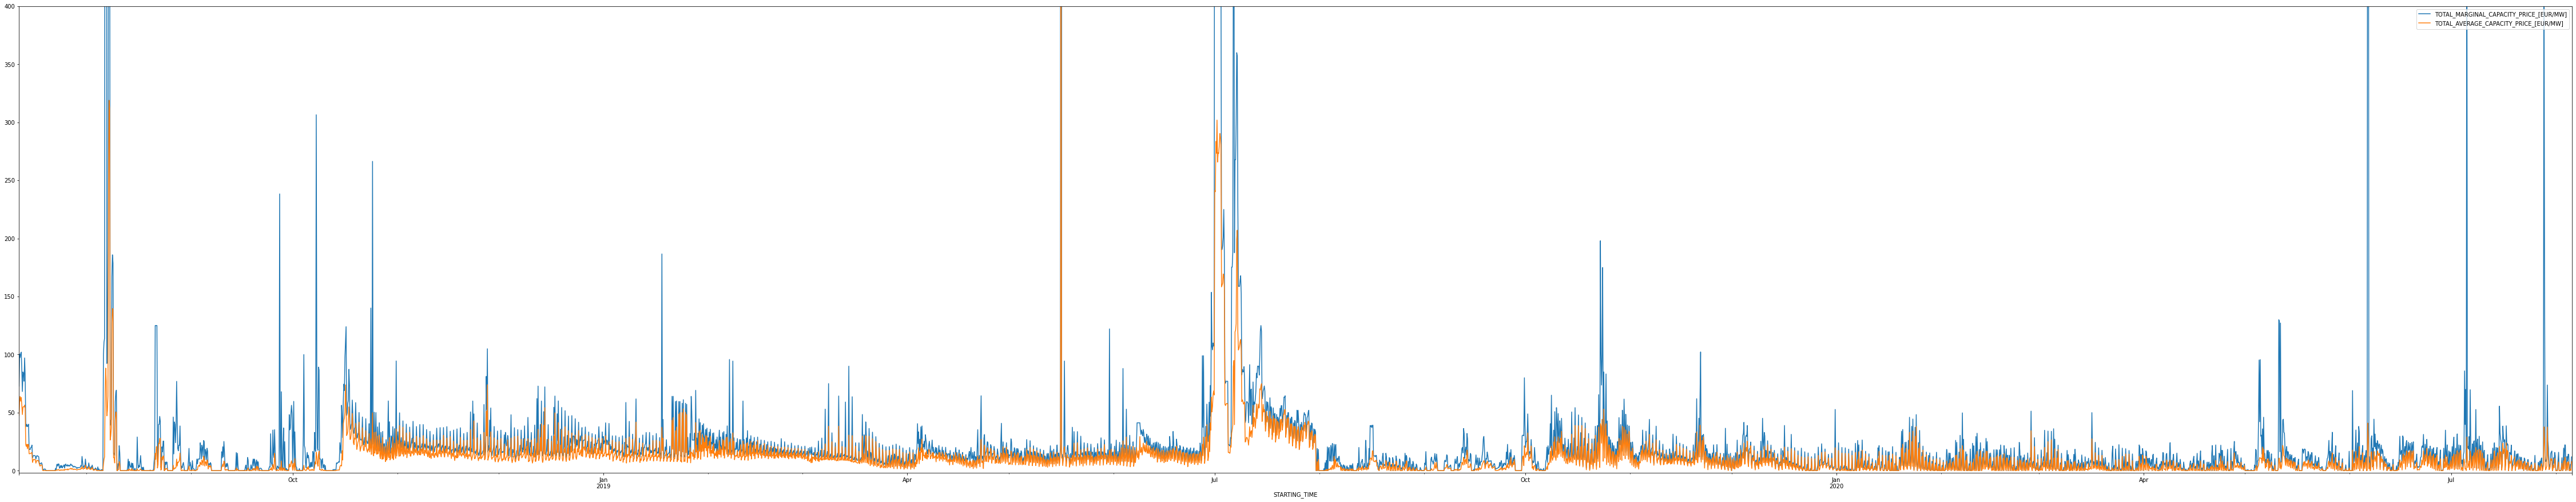

In [198]:
positiv_leistung.plot(figsize=(80,15), ylim=(-2,400))

# 2.2. Outlier Events: marginal `positiv Leistungspreis`

There are not many outliers and most of them happen in a consecutive manner.

The event happenend on 

1. May 16th 2019 

was an extreme situation.
Other events happened: 

2. August 6th and 7th 2018 afternoon, 
3. July 1st and 2nd 2019, 
4. June 6th 2020, 
5. July 5th 2020, 
6. July 28th 2020. 

To note solar eclipses had nothing to do with those events.
On August 6th 2018 and May 16th 2019 the bidding processes were unusual because bids (Gebot) were called twice for all day long (6 times). This analysis will be covered at the end of the note.

In [199]:
def select_outlier(df, bidding_pattern, threshold, filter=False):
    if (bidding_pattern not in ['CAPACITY', 'ENERGY']):
        raise ValueError
    h = set_unit(bidding_pattern)
    selection = df[f'TOTAL_MARGINAL_{bidding_pattern}_PRICE_[EUR/MW{h}]'] > threshold
    if filter:
        selection = (selection == False)
    return df[selection]

In [200]:
select_outlier(positiv_leistung, 'CAPACITY', 400)

,TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW],TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]
STARTING_TIME,,
2018-08-06 12:00:00,950.57,65.14
2018-08-06 16:00:00,1139.57,88.31
2018-08-06 20:00:00,1117.53,77.10
2018-08-07 12:00:00,500.00,244.33
2018-08-07 16:00:00,587.77,319.00
2018-08-07 20:00:00,569.23,311.86
2019-05-16 12:00:00,99900.00,490.81
2019-07-01 00:00:00,979.70,241.32
2019-07-01 04:00:00,978.89,240.31


# 2.3. Seasonal pattern: marginal and average `positiv Leistungspreis`

Plotted the seasonal mean. The price fluctuation does not show specific seasonal patterns.

In [201]:
def plot_seasonal(df, bidding_pattern, price_pattern):
    if (price_pattern not in ['MARGINAL', 'AVERAGE']) or (bidding_pattern not in ['CAPACITY', 'ENERGY']):
        raise ValueError
    h = set_unit(bidding_pattern)
    seasonal = df[f'TOTAL_{price_pattern}_{bidding_pattern}_PRICE_[EUR/MW{h}]'].groupby(by=[df.index.year, df.index.month]).mean()
    seasonal.plot()

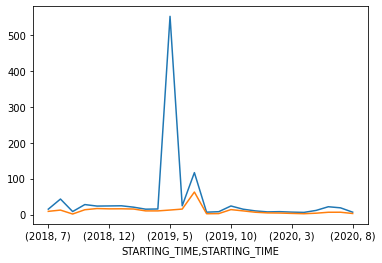

In [202]:
for p in ['MARGINAL', 'AVERAGE']:
    plot_seasonal(positiv_leistung, 'CAPACITY', p)

# 2.4. distribution of differences between marginal price and average price: `positiv Leistungsmarkt`

In [203]:
def distribution_difference(df, bidding_pattern):
    h = set_unit(bidding_pattern)
    df[f'DIFFERENCE_MAGINAL_AND_AVERAGE_{bidding_pattern}_PRICE_[EUR/MW{h}]'] = df[f'TOTAL_MARGINAL_{bidding_pattern}_PRICE_[EUR/MW{h}]'] - df[f'TOTAL_AVERAGE_{bidding_pattern}_PRICE_[EUR/MW{h}]'] 
    m = df.mean()
    s = df.std()
    print('============ MEAN ============\n', m, '\n')
    print('======= STANDARD DEV =========\n', s, '\n')
    print('Average price ratio maginal prices over average prices: ', m[f'TOTAL_MARGINAL_{bidding_pattern}_PRICE_[EUR/MW{h}]']/m[f'TOTAL_AVERAGE_{bidding_pattern}_PRICE_[EUR/MW{h}]'])

In [204]:
distribution_difference(positiv_leistung, 'CAPACITY')

============ MEAN ============
 TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]                    42.966962
TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]                     11.290518
DIFFERENCE_MAGINAL_AND_AVERAGE_CAPACITY_PRICE_[EUR/MW]    31.676444
dtype: float64 

======= STANDARD DEV =========
 TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]                    1484.177737
TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]                       22.174869
DIFFERENCE_MAGINAL_AND_AVERAGE_CAPACITY_PRICE_[EUR/MW]    1476.565014
dtype: float64 

Average price ratio maginal prices over average prices:  3.805579317601769


### a similar experiment after excluding outliers

In [205]:
positiv_leistung_wo_outlier = select_outlier(positiv_leistung, 'CAPACITY', 400, filter=True)
distribution_difference(positiv_leistung_wo_outlier, 'CAPACITY')

============ MEAN ============
 TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]                    17.238867
TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]                     10.198630
DIFFERENCE_MAGINAL_AND_AVERAGE_CAPACITY_PRICE_[EUR/MW]     7.040237
dtype: float64 

======= STANDARD DEV =========
 TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]                    24.431573
TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]                     14.074065
DIFFERENCE_MAGINAL_AND_AVERAGE_CAPACITY_PRICE_[EUR/MW]    14.370864
dtype: float64 

Average price ratio maginal prices over average prices:  1.6903120504664348


<ipython-input-203-5130f1ff7fd3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'DIFFERENCE_MAGINAL_AND_AVERAGE_{bidding_pattern}_PRICE_[EUR/MW{h}]'] = df[f'TOTAL_MARGINAL_{bidding_pattern}_PRICE_[EUR/MW{h}]'] - df[f'TOTAL_AVERAGE_{bidding_pattern}_PRICE_[EUR/MW{h}]']


## Histogram of differences

There is a quite huge room to optimize

In [206]:
def histogram_differences(df, bidding_pattern, b=np.linspace(0,150,30)):
    h = '' if bidding_pattern == 'CAPACITY' else 'h'
    df[f'DIFFERENCE_MAGINAL_AND_AVERAGE_{bidding_pattern}_PRICE_[EUR/MW{h}]'].plot(kind='hist', bins=b)
    plt.show()
    print('** in percentage')
    (df[f'DIFFERENCE_MAGINAL_AND_AVERAGE_{bidding_pattern}_PRICE_[EUR/MW{h}]']/df[f'TOTAL_MARGINAL_{bidding_pattern}_PRICE_[EUR/MW{h}]']).plot(kind='hist', bins=np.linspace(0,1,20))
    

=============== all data ================


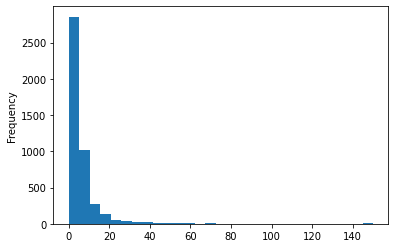

** in percentage


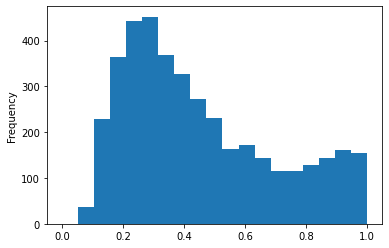

=========== without outliers ============


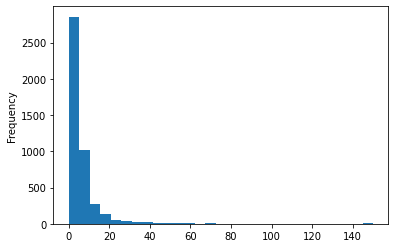

** in percentage


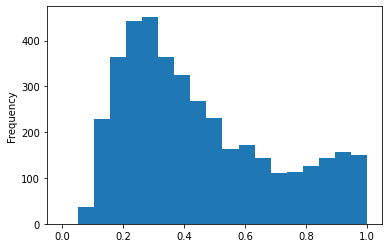

=========== excluding zeros ============


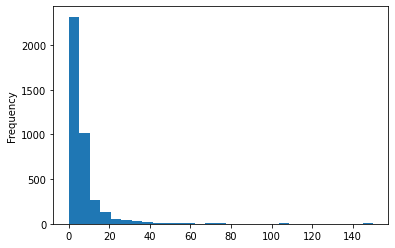

** in percentage


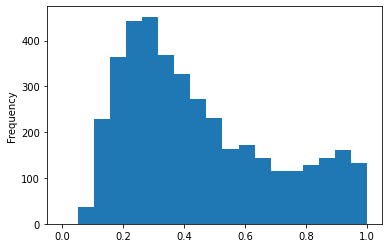

In [207]:
print('=============== all data ================')
histogram_differences(positiv_leistung, 'CAPACITY')
plt.show()
print('=========== without outliers ============')
histogram_differences(positiv_leistung_wo_outlier, 'CAPACITY')
plt.show()
print('=========== excluding zeros ============')
histogram_differences(positiv_leistung[positiv_leistung['TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]']!=0], 'CAPACITY')

# 3. Negativ Leistungsmarkt

In [208]:
negativ_leistung = filter_market('NEG', 'CAPACITY', biddings_summary)

# 3.1 Price Fluctuation: marginal and average `negativ Leistungspreis`

<AxesSubplot:xlabel='STARTING_TIME'>

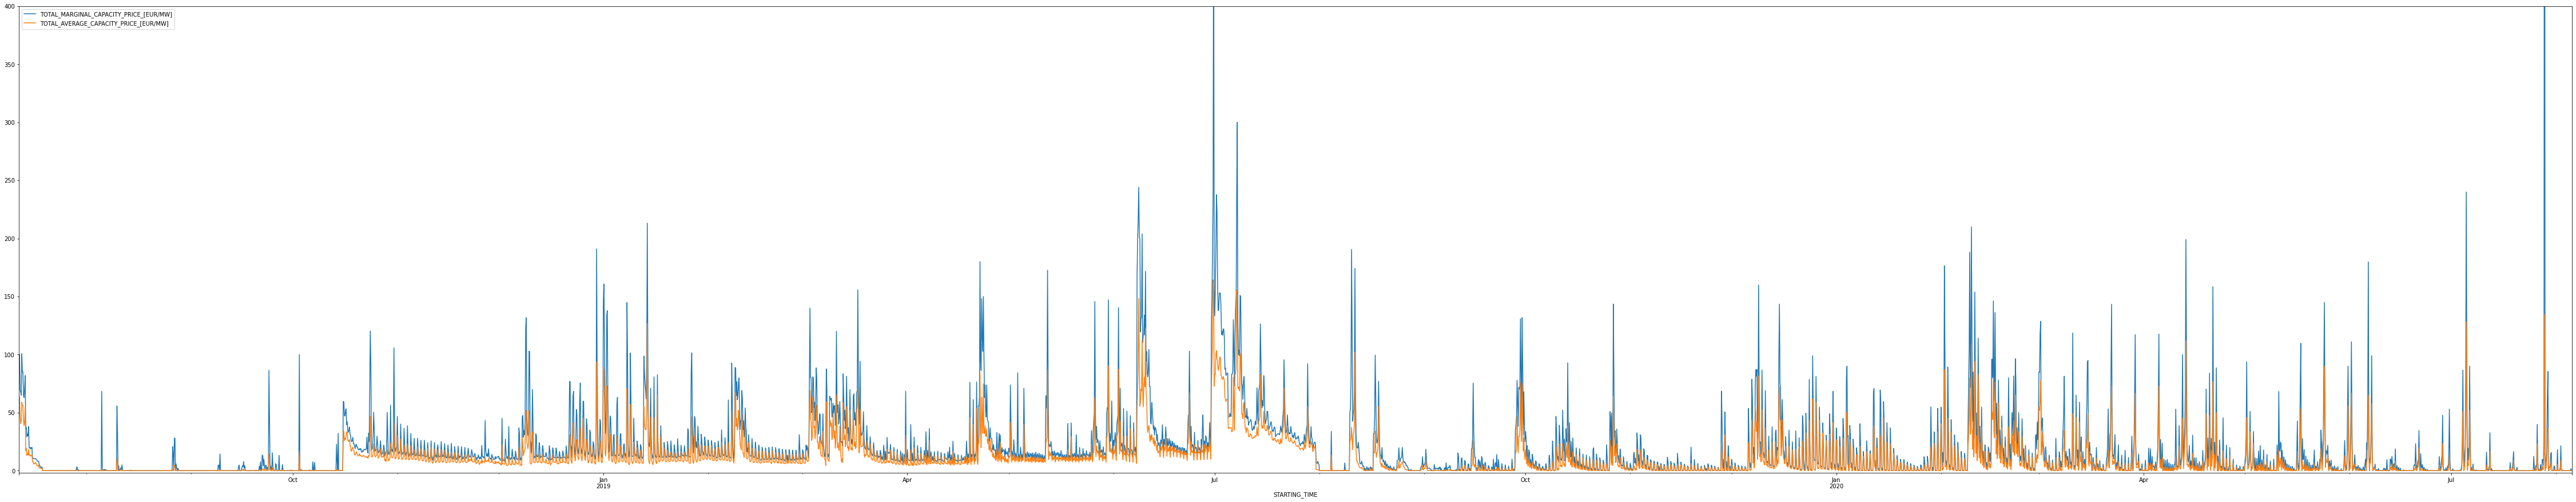

In [209]:
negativ_leistung.plot(figsize=(80,15), ylim=(-2,400))

# 3.2. Outlier Events: marginal `negativ Leistungspreis`

The negative market is much more stable.

Note that one of the outlier events for the positive market also happened on 6. July 28th 2020 but earlier on the day. 

In [210]:
select_outlier(negativ_leistung, 'CAPACITY', 400)

,TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW],TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]
STARTING_TIME,,
2019-06-30 16:00:00,500.0,160.90
2020-07-28 16:00:00,969.0,134.61


# 3.3. Seasonal pattern: marginal and average `negativ Leistungspreis`

Plotted the seasonal mean. The price fluctuation does not show specific seasonal patterns.

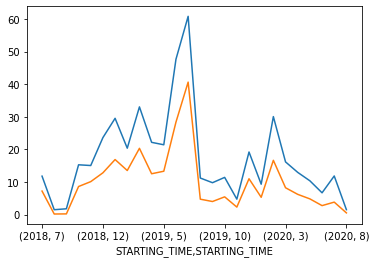

In [211]:
for p in ['MARGINAL', 'AVERAGE']:
    plot_seasonal(negativ_leistung, 'CAPACITY', p)

# 3.4. distribution of differences between marginal price and average price: `negativ Leistungsmarkt`

In [212]:
distribution_difference(negativ_leistung, 'CAPACITY')

============ MEAN ============
 TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]                    18.297337
TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]                     10.379054
DIFFERENCE_MAGINAL_AND_AVERAGE_CAPACITY_PRICE_[EUR/MW]     7.918283
dtype: float64 

======= STANDARD DEV =========
 TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]                    32.893623
TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]                     16.498691
DIFFERENCE_MAGINAL_AND_AVERAGE_CAPACITY_PRICE_[EUR/MW]    19.213196
dtype: float64 

Average price ratio maginal prices over average prices:  1.7629098422898009


### a similar experiment after excluding outliers

In [213]:
negativ_leistung_wo_outlier = select_outlier(negativ_leistung, 'CAPACITY', 400, filter=True)
distribution_difference(negativ_leistung_wo_outlier, 'CAPACITY')

============ MEAN ============
 TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]                    17.981412
TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]                     10.318456
DIFFERENCE_MAGINAL_AND_AVERAGE_CAPACITY_PRICE_[EUR/MW]     7.662955
dtype: float64 

======= STANDARD DEV =========
 TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]                    28.840759
TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]                     16.245628
DIFFERENCE_MAGINAL_AND_AVERAGE_CAPACITY_PRICE_[EUR/MW]    13.941423
dtype: float64 

Average price ratio maginal prices over average prices:  1.7426455437214703


<ipython-input-203-5130f1ff7fd3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'DIFFERENCE_MAGINAL_AND_AVERAGE_{bidding_pattern}_PRICE_[EUR/MW{h}]'] = df[f'TOTAL_MARGINAL_{bidding_pattern}_PRICE_[EUR/MW{h}]'] - df[f'TOTAL_AVERAGE_{bidding_pattern}_PRICE_[EUR/MW{h}]']


## Histogram of differences

There is a quite huge room to optimize

=============== all data ================


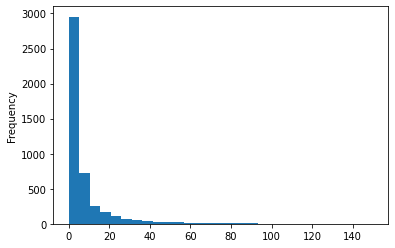

** in percentage


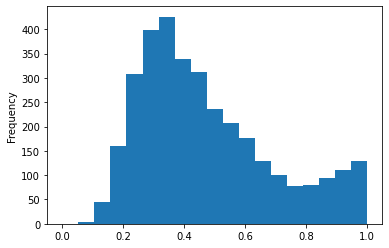

=========== without outliers ============


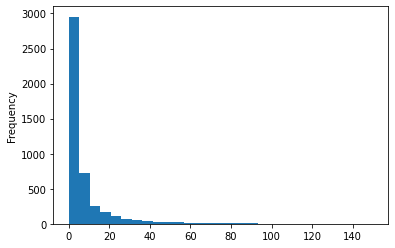

** in percentage


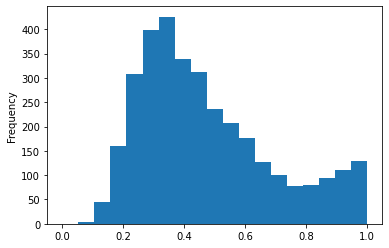

=========== excluding zeros ============


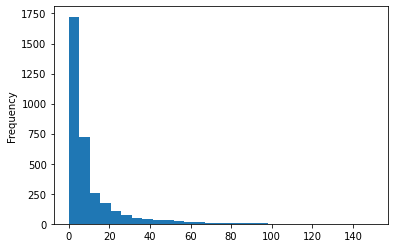

** in percentage


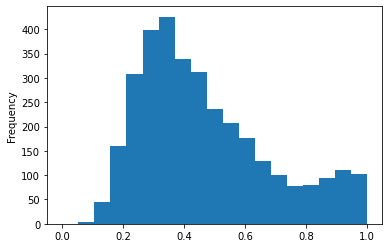

In [214]:
print('=============== all data ================')
histogram_differences(negativ_leistung, 'CAPACITY')
plt.show()
print('=========== without outliers ============')
histogram_differences(negativ_leistung_wo_outlier, 'CAPACITY')
plt.show()
print('=========== excluding zeros ============')
histogram_differences(negativ_leistung[negativ_leistung['TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]']!=0], 'CAPACITY')

# 4. Positiv Arbeitsmarkt

In [215]:
positiv_arbeit = filter_market('POS', 'ENERGY', biddings_summary)

# 4.1 Price Fluctuation: marginal and average `positiv Arbeitspreis`

<AxesSubplot:xlabel='STARTING_TIME'>

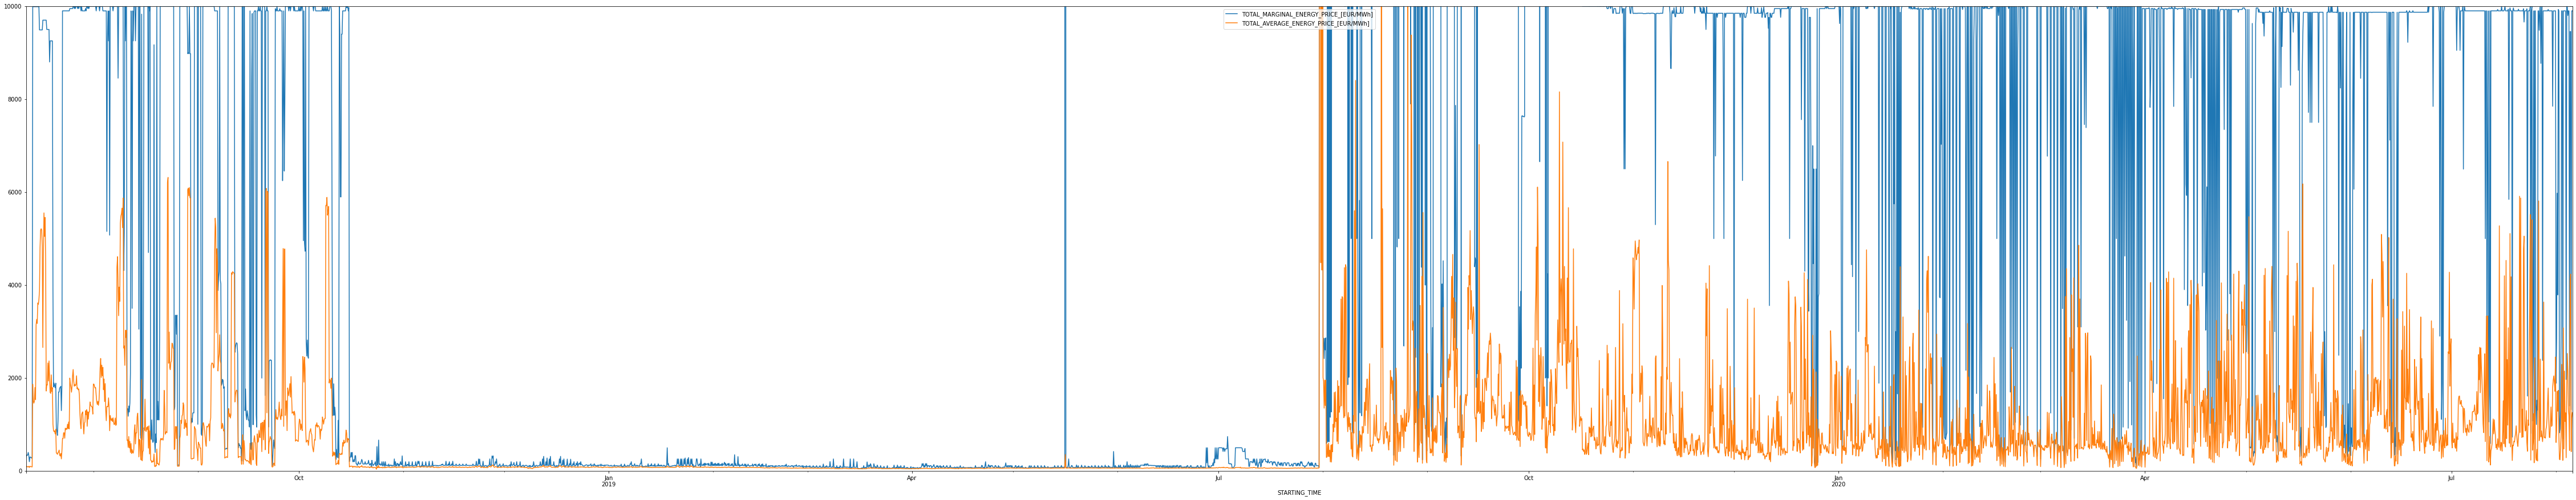

In [216]:
positiv_arbeit.plot(figsize=(80,15), ylim=(-2,10000))

# 4.2. Limit Events: marginal `positiv Arbeitspreis`

We can observe that the Arbeitsmarkt was quite often exploited due to `Mischpreisverfahren`.
2254 data points is about the quarter of the all data used here: for the quater of cases the marginal price was close to the maximum limit.

In [217]:
select_outlier(positiv_arbeit, 'ENERGY', 9000)

,TOTAL_MARGINAL_ENERGY_PRICE_[EUR/MWh],TOTAL_AVERAGE_ENERGY_PRICE_[EUR/MWh]
STARTING_TIME,,
2018-07-14 00:00:00,9990.0,1866.33
2018-07-14 04:00:00,9990.0,1512.37
2018-07-14 08:00:00,9990.0,1459.50
2018-07-14 12:00:00,9990.0,1504.20
2018-07-14 16:00:00,9990.0,1796.56
...,...,...
2020-08-04 20:00:00,9900.0,1194.73
2020-08-05 04:00:00,9456.0,4097.19
2020-08-05 08:00:00,9456.0,4234.79


# 4.3. Seasonal pattern: marginal and average `positiv Arbeitspreis`

Plotted the seasonal mean. The price fluctuation does not show specific seasonal patterns.

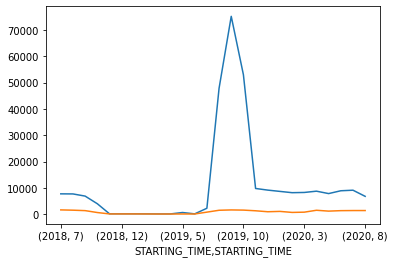

In [218]:
for p in ['MARGINAL', 'AVERAGE']:
    plot_seasonal(positiv_arbeit, 'ENERGY', p)

# 4.4. distribution of differences between marginal price and average price: `positiv Arbeitsmarkt`

In [219]:
distribution_difference(positiv_arbeit, 'ENERGY')

============ MEAN ============
 TOTAL_MARGINAL_ENERGY_PRICE_[EUR/MWh]                    11433.693071
TOTAL_AVERAGE_ENERGY_PRICE_[EUR/MWh]                       836.977524
DIFFERENCE_MAGINAL_AND_AVERAGE_ENERGY_PRICE_[EUR/MWh]    10596.715547
dtype: float64 

======= STANDARD DEV =========
 TOTAL_MARGINAL_ENERGY_PRICE_[EUR/MWh]                    23680.575422
TOTAL_AVERAGE_ENERGY_PRICE_[EUR/MWh]                      1441.931149
DIFFERENCE_MAGINAL_AND_AVERAGE_ENERGY_PRICE_[EUR/MWh]    23281.099397
dtype: float64 

Average price ratio maginal prices over average prices:  13.660693076826822


## Histogram of differences

There is a quite huge room to optimize

=============== all data ================


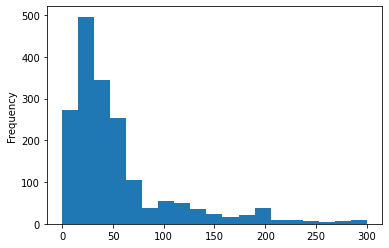

** in percentage


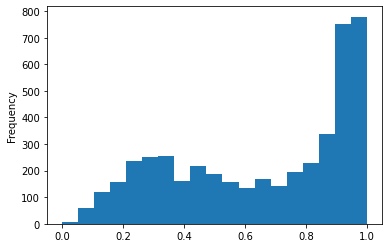

=========== excluding zeros ============


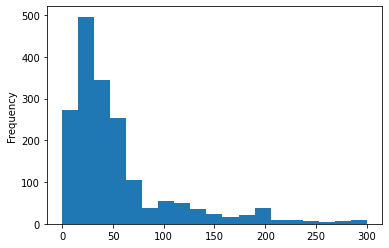

** in percentage


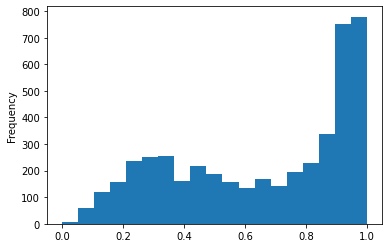

In [220]:
print('=============== all data ================')
histogram_differences(positiv_arbeit, 'ENERGY', b=np.linspace(0,300,20))
plt.show()
print('=========== excluding zeros ============')
histogram_differences(positiv_arbeit[positiv_arbeit['TOTAL_AVERAGE_ENERGY_PRICE_[EUR/MWh]']!=0], 'ENERGY',  b=np.linspace(0,300,20))

# 5. Negativ Arbeitsmarkt

In [221]:
negativ_arbeit = filter_market('NEG', 'ENERGY', biddings_summary)

# 5.1 Price Fluctuation: marginal and average `negativ Arbeitspreis`

<AxesSubplot:xlabel='STARTING_TIME'>

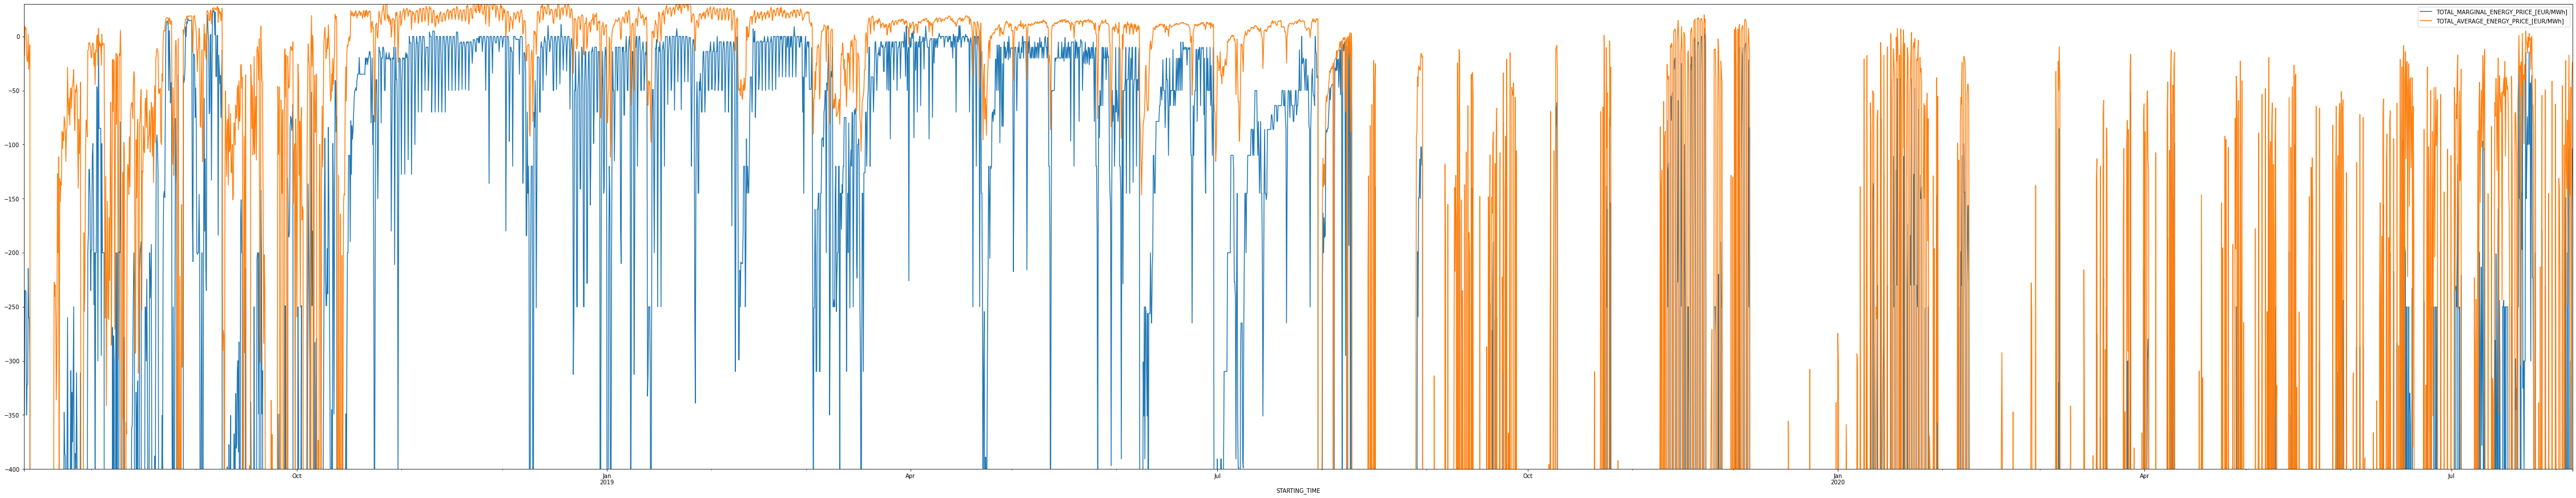

In [222]:
negativ_arbeit.plot(figsize=(80,15), ylim=(-400,30))

# 5.2. Outlier Events: marginal `negativ Arbeitspreis`

Negativ Arbeitmarkt has even more fluctuation than positiv Arbeitsmarkt. About 1/6 of the data have quite extreme values.

In [223]:
select_outlier(negativ_arbeit, 'ENERGY', -9000, filter=True)

,TOTAL_MARGINAL_ENERGY_PRICE_[EUR/MWh],TOTAL_AVERAGE_ENERGY_PRICE_[EUR/MWh]
STARTING_TIME,,
2018-07-14 00:00:00,-90000.0,-1626.63
2018-07-14 04:00:00,-90000.0,-2272.52
2018-07-14 08:00:00,-90000.0,-1260.75
2018-07-14 12:00:00,-90000.0,-1258.35
2018-07-14 16:00:00,-90000.0,-1248.90
...,...,...
2020-08-01 12:00:00,-9980.0,-921.94
2020-08-02 08:00:00,-9980.0,-905.06
2020-08-02 12:00:00,-9980.0,-857.17


# 5.3. Seasonal pattern: marginal and average `negativ Arbeitspreis`

Plotted the seasonal mean. The price fluctuation does not show specific seasonal patterns.

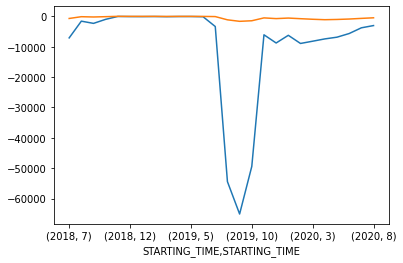

In [224]:
for p in ['MARGINAL', 'AVERAGE']:
    plot_seasonal(negativ_arbeit, 'ENERGY', p)

# 5.4. distribution of differences between marginal price and average price: `negativ Arbeitsmarkt`

In [226]:
distribution_difference(negativ_arbeit, 'ENERGY')

============ MEAN ============
 TOTAL_MARGINAL_ENERGY_PRICE_[EUR/MWh]                   -9884.496551
TOTAL_AVERAGE_ENERGY_PRICE_[EUR/MWh]                     -490.232224
DIFFERENCE_MAGINAL_AND_AVERAGE_ENERGY_PRICE_[EUR/MWh]   -9394.264326
dtype: float64 

======= STANDARD DEV =========
 TOTAL_MARGINAL_ENERGY_PRICE_[EUR/MWh]                    24353.070482
TOTAL_AVERAGE_ENERGY_PRICE_[EUR/MWh]                       768.125844
DIFFERENCE_MAGINAL_AND_AVERAGE_ENERGY_PRICE_[EUR/MWh]    23818.536889
dtype: float64 

Average price ratio maginal prices over average prices:  20.162886195950666


## Histogram of differences

There is a quite huge room to optimize

=============== all data ================


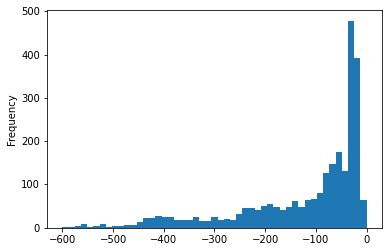

** in percentage


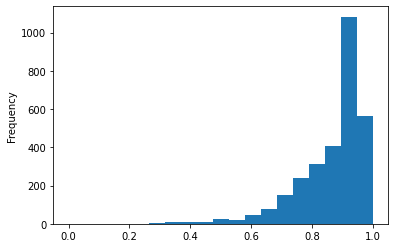

=========== excluding zeros ============


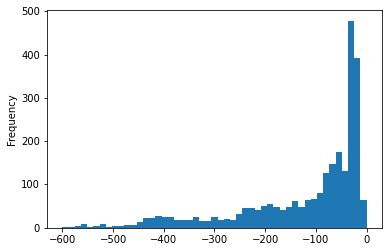

** in percentage


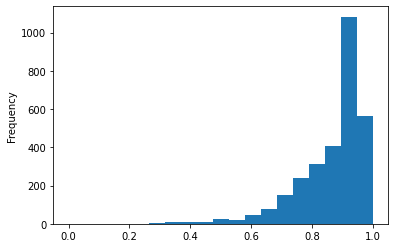

In [227]:
print('=============== all data ================')
histogram_differences(negativ_arbeit, 'ENERGY', b=np.linspace(-600,0,50))
plt.show()
print('=========== excluding zeros ============')
histogram_differences(negativ_arbeit[negativ_arbeit['TOTAL_AVERAGE_ENERGY_PRICE_[EUR/MWh]']!=0], 'ENERGY', b=np.linspace(-600,0,50))

# 6. Unusual bidding process

On August 6th 2018 and on May 16th 2019 the tenders were called twice with a week ealier `GATE_OPEN_TIME`. It happened both for the positive market and the negative market.

In [233]:
tenders = []
for year in range(18,21,1):
    tenders.append(pd.read_excel(f'https://www.regelleistung.net/apps/cpp-publisher/api/v1/download/tenders/files/LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_20{year}-01-01_20{year}-12-31.xlsx'))
tenders_1820 = pd.concat(tenders)

add_starting_time(tenders_1820) 
tenders_1820.head()

Total data points:  9168


,DATE_FROM,DATE_TO,GATE_OPEN_TIME,GATE_CLOSURE_TIME,ALLOCATION_DEADLINE,TENDER_TYPE,ROUND,TYPE_OF_RESERVES,PRODUCT,TOTAL_DEMAND_[MW],...,GERMANY_BLOCK_EXPORT_LIMIT_[MW],GERMANY_BLOCK_CORE_PORTION_[MW],TRANSNETBW_AREA_CORE_PORTION_[MW],AMPRION_AREA_CORE_PORTION_[MW],50HERTZ_AREA_CORE_PORTION_[MW],TENNET_AREA_CORE_PORTION_[MW],AUSTRIA_BLOCK_DEMAND_[MW],AUSTRIA_BLOCK_EXPORT_LIMIT_[MW],AUSTRIA_BLOCK_CORE_PORTION_[MW],APG_AREA_CORE_PORTION_[MW]
STARTING_TIME,,,,,,,,,,,,,,,,,,,,,
2018-07-12 00:00:00,2018-07-12,2018-07-12,2018-07-05 10:00:00,2018-07-11 08:00:00,2018-07-11 09:00:00,DAILY,1,aFRR,NEG_00_04,1759,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-07-12 04:00:00,2018-07-12,2018-07-12,2018-07-05 10:00:00,2018-07-11 08:00:00,2018-07-11 09:00:00,DAILY,1,aFRR,NEG_04_08,1759,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-07-12 08:00:00,2018-07-12,2018-07-12,2018-07-05 10:00:00,2018-07-11 08:00:00,2018-07-11 09:00:00,DAILY,1,aFRR,NEG_08_12,1759,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-07-12 12:00:00,2018-07-12,2018-07-12,2018-07-05 10:00:00,2018-07-11 08:00:00,2018-07-11 09:00:00,DAILY,1,aFRR,NEG_12_16,1759,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-07-12 16:00:00,2018-07-12,2018-07-12,2018-07-05 10:00:00,2018-07-11 08:00:00,2018-07-11 09:00:00,DAILY,1,aFRR,NEG_16_20,1759,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN


In [234]:
def filter_product(df, product):
    if product not in ['NEG', 'POS']:
        raise ValueError
    return df[df['PRODUCT'].str[0:3] == product]

tenders_pos = filter_product(tenders_1820, 'POS')
tenders_neg = filter_product(tenders_1820, 'NEG')

def show_duplicated(df):
    return df[df.index.duplicated(keep=False)]

In [235]:
show_duplicated(tenders_pos)

,DATE_FROM,DATE_TO,GATE_OPEN_TIME,GATE_CLOSURE_TIME,ALLOCATION_DEADLINE,TENDER_TYPE,ROUND,TYPE_OF_RESERVES,PRODUCT,TOTAL_DEMAND_[MW],...,GERMANY_BLOCK_EXPORT_LIMIT_[MW],GERMANY_BLOCK_CORE_PORTION_[MW],TRANSNETBW_AREA_CORE_PORTION_[MW],AMPRION_AREA_CORE_PORTION_[MW],50HERTZ_AREA_CORE_PORTION_[MW],TENNET_AREA_CORE_PORTION_[MW],AUSTRIA_BLOCK_DEMAND_[MW],AUSTRIA_BLOCK_EXPORT_LIMIT_[MW],AUSTRIA_BLOCK_CORE_PORTION_[MW],APG_AREA_CORE_PORTION_[MW]
STARTING_TIME,,,,,,,,,,,,,,,,,,,,,
2018-08-06 00:00:00,2018-08-06,2018-08-06,2018-08-05 08:50:00,2018-08-05 13:30:00,2018-08-05 14:30:00,DAILY,2,aFRR,POS_00_04,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 00:00:00,2018-08-06,2018-08-06,2018-07-30 10:00:00,2018-08-05 08:00:00,2018-08-05 09:00:00,DAILY,1,aFRR,POS_00_04,1883,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 04:00:00,2018-08-06,2018-08-06,2018-07-30 10:00:00,2018-08-05 08:00:00,2018-08-05 09:00:00,DAILY,1,aFRR,POS_04_08,1883,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 04:00:00,2018-08-06,2018-08-06,2018-08-05 08:50:00,2018-08-05 13:30:00,2018-08-05 14:30:00,DAILY,2,aFRR,POS_04_08,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 08:00:00,2018-08-06,2018-08-06,2018-07-30 10:00:00,2018-08-05 08:00:00,2018-08-05 09:00:00,DAILY,1,aFRR,POS_08_12,1883,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 08:00:00,2018-08-06,2018-08-06,2018-08-05 08:50:00,2018-08-05 13:30:00,2018-08-05 14:30:00,DAILY,2,aFRR,POS_08_12,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 12:00:00,2018-08-06,2018-08-06,2018-07-30 10:00:00,2018-08-05 08:00:00,2018-08-05 09:00:00,DAILY,1,aFRR,POS_12_16,1883,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 12:00:00,2018-08-06,2018-08-06,2018-08-05 08:50:00,2018-08-05 13:30:00,2018-08-05 14:30:00,DAILY,2,aFRR,POS_12_16,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 16:00:00,2018-08-06,2018-08-06,2018-08-05 08:50:00,2018-08-05 13:30:00,2018-08-05 14:30:00,DAILY,2,aFRR,POS_16_20,24,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN


In [232]:
show_duplicated(tenders_neg)

,DATE_FROM,DATE_TO,GATE_OPEN_TIME,GATE_CLOSURE_TIME,ALLOCATION_DEADLINE,TENDER_TYPE,ROUND,TYPE_OF_RESERVES,PRODUCT,TOTAL_DEMAND_[MW],...,GERMANY_BLOCK_EXPORT_LIMIT_[MW],GERMANY_BLOCK_CORE_PORTION_[MW],TRANSNETBW_AREA_CORE_PORTION_[MW],AMPRION_AREA_CORE_PORTION_[MW],50HERTZ_AREA_CORE_PORTION_[MW],TENNET_AREA_CORE_PORTION_[MW],AUSTRIA_BLOCK_DEMAND_[MW],AUSTRIA_BLOCK_EXPORT_LIMIT_[MW],AUSTRIA_BLOCK_CORE_PORTION_[MW],APG_AREA_CORE_PORTION_[MW]
STARTING_TIME,,,,,,,,,,,,,,,,,,,,,
2018-08-06 00:00:00,2018-08-06,2018-08-06,2018-07-30 10:00:00,2018-08-05 08:00:00,2018-08-05 09:00:00,DAILY,1,aFRR,NEG_00_04,1759,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 00:00:00,2018-08-06,2018-08-06,2018-08-05 08:50:00,2018-08-05 13:30:00,2018-08-05 14:30:00,DAILY,2,aFRR,NEG_00_04,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 04:00:00,2018-08-06,2018-08-06,2018-08-05 08:50:00,2018-08-05 13:30:00,2018-08-05 14:30:00,DAILY,2,aFRR,NEG_04_08,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 04:00:00,2018-08-06,2018-08-06,2018-07-30 10:00:00,2018-08-05 08:00:00,2018-08-05 09:00:00,DAILY,1,aFRR,NEG_04_08,1759,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 08:00:00,2018-08-06,2018-08-06,2018-07-30 10:00:00,2018-08-05 08:00:00,2018-08-05 09:00:00,DAILY,1,aFRR,NEG_08_12,1759,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 08:00:00,2018-08-06,2018-08-06,2018-08-05 08:50:00,2018-08-05 13:30:00,2018-08-05 14:30:00,DAILY,2,aFRR,NEG_08_12,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 12:00:00,2018-08-06,2018-08-06,2018-07-30 10:00:00,2018-08-05 08:00:00,2018-08-05 09:00:00,DAILY,1,aFRR,NEG_12_16,1759,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 12:00:00,2018-08-06,2018-08-06,2018-08-05 08:50:00,2018-08-05 13:30:00,2018-08-05 14:30:00,DAILY,2,aFRR,NEG_12_16,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2018-08-06 16:00:00,2018-08-06,2018-08-06,2018-08-05 08:50:00,2018-08-05 13:30:00,2018-08-05 14:30:00,DAILY,2,aFRR,NEG_16_20,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
